# 01 - Data Exploration

This project will analyse UK energy consumption data published by from data.gov.uk

## Prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import energy_forecast
from energy_forecast.loaders import load_ods, load_ods_sheetnames

import requests, zipfile, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot


In [8]:
REPO_ROOT = Path.cwd().parent
REPO_ROOT
DATA_RAW = REPO_ROOT / 'data' / 'raw'
ENERGY_PATH = DATA_RAW / 'ET_1.2_SEP_22.xlsx'
ENERGY_PATH2 = DATA_RAW / 'Total_Energy_ODS.ods'
ENERGY_SHEETNAME = '1_2'

# Weather
WEATHER_PATH = DATA_RAW / 'Weather_ODS.ods'
TEMP_SHEET = '7_1a'

In [16]:
# Load the energy data 
def load_ods_by_sheetname(path: str, sheet_name: str) -> pd.DataFrame:
    names = load_ods_sheetnames(path)
    if sheet_name not in names:
        raise ValueError(f'Can\'t find sheet name "{sheet_name}" in ods file')
    return load_ods(path, sheet_name)

energy = load_ods(ENERGY_PATH2, ENERGY_SHEETNAME)

In [17]:
def drop_provisional_rows(df):
    return df[~df.month.str.contains('\[provisional\]')]

def remove_notes(df):
    df.columns = df.columns.str.replace(r'\[.*\]','', regex=True)
    df.columns = df.columns.str.strip()
    return df

col_renamer = {
    'primary electricity - net imports': 'elec_import',
    'primary electricity - wind, solar and hydro': 'elec_renewable',
    'primary electricity - nuclear': 'elec_nuclear'
}

def clean_energy_data(df):
    df = (df
        .set_axis(df.iloc[3, :].tolist(),
                  axis=1)
        .rename(columns=str.lower)
        .iloc[4:]
        .pipe(drop_provisional_rows)
        .reset_index(drop=True)
        .pipe(remove_notes)
        .iloc[:,:9]
        .rename(columns=col_renamer)
    )
    return df

clean_energy_data(energy)

,month,unadjusted total,coal,petroleum,natural gas,bioenergy & waste,elec_nuclear,elec_renewable,elec_import
0,January 1995,21.03,4.32,6.16,8.9,0.14,1.51,[x],[x]
1,February 1995,20,4.79,6.32,7.16,0.14,1.59,[x],[x]
2,March 1995,22.54,5.62,6.96,7.91,0.14,1.91,[x],[x]
3,April 1995,17.58,3.83,6.08,5.75,0.14,1.78,[x],[x]
4,May 1995,16.43,3.72,6.23,4.79,0.14,1.55,[x],[x]
...,...,...,...,...,...,...,...,...,...
325,February 2022,15.59,0.49,4.88,6.68,1.62,0.79,0.97,0.16
326,March 2022,15.49,0.54,5.01,6.54,1.62,0.97,0.67,0.14
327,April 2022,14.41,0.49,5.19,5.91,1.28,0.9,0.65,-0.01
328,May 2022,12.87,0.36,5.21,4.57,1.28,0.94,0.68,-0.17


# Weather data

In [21]:
def remove_average(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.replace(r'average', '', regex=True)
    return df

def load_cleaned_temp(df: pd.DataFrame) -> pd.DataFrame:
    """Applies cleaning and transform steps on temperature data"""
    df = (df
        .set_axis(df.iloc[3, :].tolist(),
            axis=1)
        .iloc[4:16]
        .rename(columns=str.lower)
        .rename(columns={'calendar period': 'month'})
        .pipe(remove_notes)
        .pipe(remove_average)
        .drop(columns=['30-year mean'])
        .replace('[x]', np.nan)
        .melt(id_vars='month', var_name='year', value_name='temp')
        .assign(datetime=lambda x: x.month + ' ' + x.year)
        .assign(datetime=lambda x: pd.to_datetime(x.datetime))
        .drop(columns=['month', 'year'])
        .set_index('datetime')
    )
    return df

# Load the temperature data and clean it
temp = load_ods_by_sheetname(WEATHER_PATH, TEMP_SHEET)    
temp = load_cleaned_temp(temp)
temp

,temp
datetime,
1991-01-01,3.700000
1991-02-01,2.400000
1991-03-01,7.800000
1991-04-01,8.000000
1991-05-01,11.000000
...,...
2022-08-01,18.315515
2022-09-01,NaN
2022-10-01,NaN


In [27]:
def load_cleaned_wind(df: pd.DataFrame) -> pd.DataFrame:
    """Applies cleaning and transform steps on temperature data"""
    df = (df
        .set_axis(df.iloc[3, :].tolist(),
            axis=1)
        .iloc[4:16]
        .rename(columns=str.lower)
        .rename(columns={'calendar period': 'month'})
        .pipe(remove_notes)
        .pipe(remove_average)
        .drop(columns=['20-year mean'])
        .replace('[x]', np.nan)
        .melt(id_vars='month', var_name='year', value_name='wind')
        .assign(datetime=lambda x: x.month + ' ' + x.year)
        .assign(datetime=lambda x: pd.to_datetime(x.datetime))
        .drop(columns=['month', 'year'])
        .set_index('datetime')
    )
    return df

wind = load_ods_by_sheetname(WEATHER_PATH, '7_2')
wind = load_cleaned_wind(wind)
wind

,wind
datetime,
2001-01-01,8.425950
2001-02-01,8.703050
2001-03-01,9.246000
2001-04-01,8.893600
2001-05-01,7.419400
...,...
2022-08-01,6.522037
2022-09-01,NaN
2022-10-01,NaN


In [43]:
def load_cleaned_sun(df: pd.DataFrame) -> pd.DataFrame:
    """Applies cleaning and transform steps on temperature data"""
    df = (df
        .set_axis(df.iloc[3, :].tolist(),
            axis=1)
        .iloc[4:16]
        .rename(columns=str.lower)
        .rename(columns={'calendar period': 'month'})
        .pipe(remove_notes)
        .pipe(remove_average)
        .drop(columns=['20-year mean'])
        .replace('[x]', np.nan)
        .melt(id_vars='month', var_name='year', value_name='sun')
        .assign(datetime=lambda x: x.month + ' ' + x.year)
        .assign(datetime=lambda x: pd.to_datetime(x.datetime))
        .drop(columns=['month', 'year'])
        .set_index('datetime')
    )
    return df

sun = load_ods_by_sheetname(WEATHER_PATH, '7_3')
sun = load_cleaned_sun(sun)
sun

,sun
datetime,
2001-01-01,2.448102
2001-02-01,3.125319
2001-03-01,2.953300
2001-04-01,4.744445
2001-05-01,7.725524
...,...
2022-08-01,7.797510
2022-09-01,NaN
2022-10-01,NaN


In [33]:
def load_cleaned_rain(df: pd.DataFrame) -> pd.DataFrame:
    """Applies cleaning and transform steps on temperature data"""
    df = (df
        .set_axis(df.iloc[3, :].tolist(),
            axis=1)
        .iloc[4:16]
        .rename(columns=str.lower)
        .rename(columns={'calendar period': 'month'})
        .pipe(remove_notes)
        .pipe(remove_average)
        .drop(columns=['20-year mean'])
        .replace('[x]', np.nan)
        .melt(id_vars='month', var_name='year', value_name='rain')
        .assign(datetime=lambda x: x.month + ' ' + x.year)
        .assign(datetime=lambda x: pd.to_datetime(x.datetime))
        .drop(columns=['month', 'year'])
        .set_index('datetime')
    )
    return df

rain = load_ods_by_sheetname(WEATHER_PATH, '7_4')
rain = load_cleaned_rain(rain)
rain

,rain
datetime,
2001-01-01,103.481072
2001-02-01,77.799117
2001-03-01,67.968746
2001-04-01,64.001636
2001-05-01,32.301995
...,...
2022-08-01,74.999743
2022-09-01,NaN
2022-10-01,NaN


In [47]:
weather = (temp
    .merge(wind, on='datetime', how='outer')
    .merge(sun, on='datetime', how='outer')
    .merge(rain, on='datetime', how='outer')
)
weather

,temp,wind,sun,rain
datetime,,,,
1991-01-01,3.700000,NaN,NaN,NaN
1991-02-01,2.400000,NaN,NaN,NaN
1991-03-01,7.800000,NaN,NaN,NaN
1991-04-01,8.000000,NaN,NaN,NaN
1991-05-01,11.000000,NaN,NaN,NaN
...,...,...,...,...
2022-08-01,18.315515,6.522037,7.79751,74.999743
2022-09-01,NaN,NaN,NaN,NaN
2022-10-01,NaN,NaN,NaN,NaN


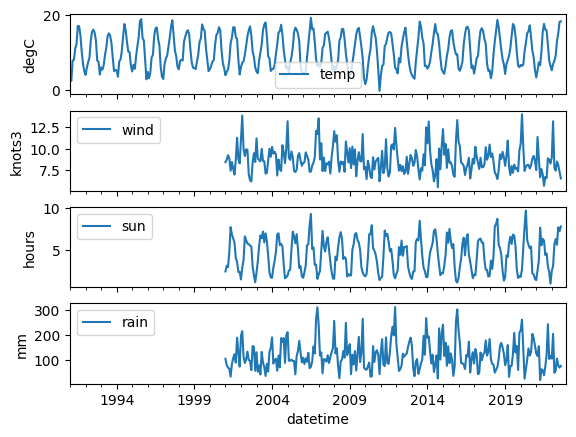

In [49]:
cols = ['temp','wind','sun','rain']
units = ['degC','knots3','hours','mm']
channels = dict(zip(cols,units))

fig = plt.figure()
for i, (col, unit) in enumerate(channels.items()):
    sharex = ax if i>0 else None
    ax = fig.add_subplot(4,1,i+1, sharex=sharex)
    weather.plot(y=col, ax=ax)
    ax.set_ylabel(unit)